Align forecasted and observed temperatures per region.
--

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

import hakom
from hakom.repositories.timeseries.data import TimeSeriesDataItemTimeStamp
import getpass

Authenticate with the service:

In [3]:
api_pwd = getpass.getpass()

········


In [4]:
auth_params = hakom.authorization.AuthParams(
    username = 'HakomUser',
    password = api_pwd,
)

service_config = hakom.service.ServiceConfig(
    base_url="https://fehostedwebapp.azurewebsites.net/MAIN/api/",
    auth_params=auth_params,
    repository='ZAMS'
)

hakom.initialize(service_config)

Check whether service is running:

In [5]:
hakom.get_config().check_health()

True

In [6]:
hakom.versioninfo.get()

{'Name': 'HAKOM WebTSM Services',
 'Description': 'Time Series Management Webservices',
 'Version': '3.9.2.1-rc+0'}

## 1. Load and plot data

Get the start and end dates of observed and forecasted temperatures: 

In [7]:
metainfo_observed = hakom.repositories.timeseries.metainfo.get('1134') # Observed temperature
metainfo_forecasted_short_term = hakom.repositories.timeseries.metainfo.get('1135') # Short-term forecast
metainfo_forecasted_long_term = hakom.repositories.timeseries.metainfo.get('1316') # Long-term forecast, based on the forecasts from different regions, [1316] Temperatura Belo Horizonte fonte GRIB 

Comment on Python client: function to load the entire time-series without passing the dates is missing

In [8]:
query_params = []
query_params.append(hakom.commons.QueryParam("id", "1134"))
query_params.append(hakom.commons.QueryParam("id", "1135"))
query_params.append(hakom.commons.QueryParam("id", "1141"))
query_params.append(hakom.commons.QueryParam("id", "1142"))
query_params.append(hakom.commons.QueryParam("id", "1133"))
query_params.append(hakom.commons.QueryParam("id", "1137"))
query_params.append(hakom.commons.QueryParam("id", "1136"))
query_params.append(hakom.commons.QueryParam("id", "1140"))
query_params.append(hakom.commons.QueryParam("id", "1315"))
query_params.append(hakom.commons.QueryParam("id", "1304"))
query_params.append(hakom.commons.QueryParam("id", "1308"))
query_params.append(hakom.commons.QueryParam("id", "1299"))
query_params.append(hakom.commons.QueryParam("from", metainfo_observed['DataPeriod']['From']))
query_params.append(hakom.commons.QueryParam("to", metainfo_forecasted_long_term['DataPeriod']['To']))


timeseries_data= hakom.repositories.timeseriescollections.data.get(query_params,hakom.errorhandling.BulkResultBehaviours.FullResult)
matrix = hakom.converters.timeseries_data_collection_matrix(timeseries_data)
 
df = pd.DataFrame(matrix)

In [9]:
df.head()

,From,Temperatura Subsistema SECO,Temperatura Subsistema SECO - Previsão ONS,Temperatura Subsistema S,Temperatura Subsistema S - Previsão ONS,Temperatura Subsistema NE,Temperatura Subsistema NE - Previsão ONS,Temperatura Subsistema N,Temperatura Subsistema N - Previsão ONS,Temperatura Subsistema SECO - Previsão GRIB,Temperatura Subsistema S - Previsão GRIB,Temperatura Subsistema NE - Previsão GRIB,Temperatura Subsistema N - Previsão GRIB
0,2017-01-01T00:00:00Z,24.889000,0.0,23.905001,0.0,27.367001,0.0,25.209999,0.0,0.0,0.0,0.0,0.0
1,2017-01-01T01:00:00Z,24.791000,0.0,22.938999,0.0,26.237000,0.0,25.080000,0.0,0.0,0.0,0.0,0.0
2,2017-01-01T02:00:00Z,24.250000,0.0,23.132999,0.0,26.219999,0.0,25.209999,0.0,0.0,0.0,0.0,0.0
3,2017-01-01T03:00:00Z,24.365000,0.0,22.650000,0.0,26.049999,0.0,25.080000,0.0,0.0,0.0,0.0,0.0
4,2017-01-01T04:00:00Z,23.674999,0.0,22.650000,0.0,25.653000,0.0,24.790001,0.0,0.0,0.0,0.0,0.0


Rename columns:

In [10]:
col_dict = {}

for col in df.columns:
    if col.__contains__('From'):
        name = col
        col_dict[col] = name
    elif col.__contains__('ONS'):
        region = col[col.find('Temperatura Subsistema')+23:col.find('-')-1]
        name = 'short_term_' + region
        col_dict[col] = name
    elif col.__contains__('GRIB'):
        region = col[col.find('Temperatura Subsistema')+23:col.find('-')-1]
        name = 'long_term_' + region
        col_dict[col] = name
    else:
        region = col[col.find('Temperatura Subsistema')+23:]
        name = 'obs_' + region
        col_dict[col] = name

In [11]:
df.rename(columns = col_dict,inplace = True)

In [12]:
df['From'] = pd.to_datetime(df['From'], format="%Y-%m-%d %H:%M:%S")

In [13]:
df.head()

,From,obs_SECO,short_term_SECO,obs_S,short_term_S,obs_NE,short_term_NE,obs_N,short_term_N,long_term_SECO,long_term_S,long_term_NE,long_term_N
0,2017-01-01 00:00:00+00:00,24.889000,0.0,23.905001,0.0,27.367001,0.0,25.209999,0.0,0.0,0.0,0.0,0.0
1,2017-01-01 01:00:00+00:00,24.791000,0.0,22.938999,0.0,26.237000,0.0,25.080000,0.0,0.0,0.0,0.0,0.0
2,2017-01-01 02:00:00+00:00,24.250000,0.0,23.132999,0.0,26.219999,0.0,25.209999,0.0,0.0,0.0,0.0,0.0
3,2017-01-01 03:00:00+00:00,24.365000,0.0,22.650000,0.0,26.049999,0.0,25.080000,0.0,0.0,0.0,0.0,0.0
4,2017-01-01 04:00:00+00:00,23.674999,0.0,22.650000,0.0,25.653000,0.0,24.790001,0.0,0.0,0.0,0.0,0.0


a. Analyze long- and short-term forecasts
--

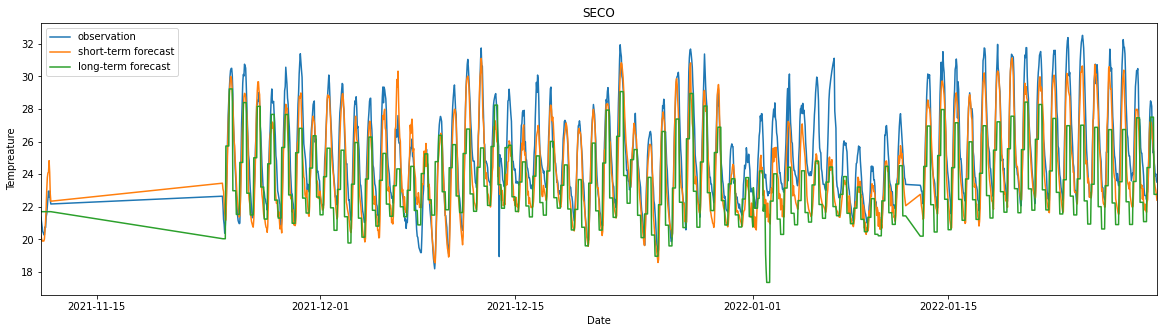

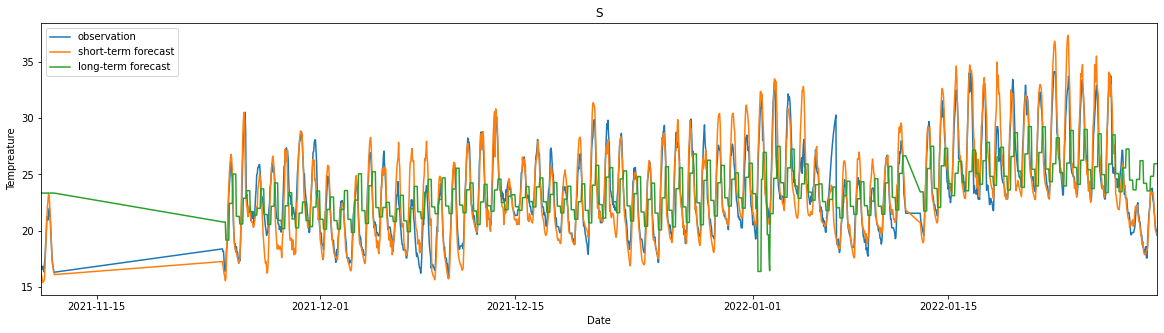

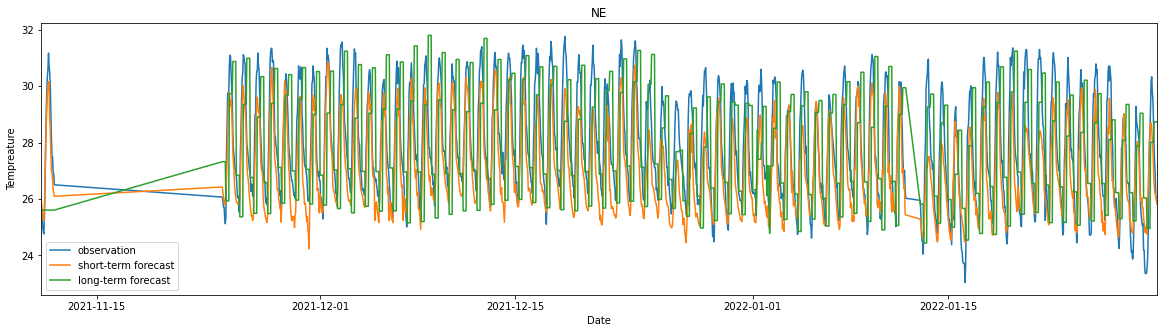

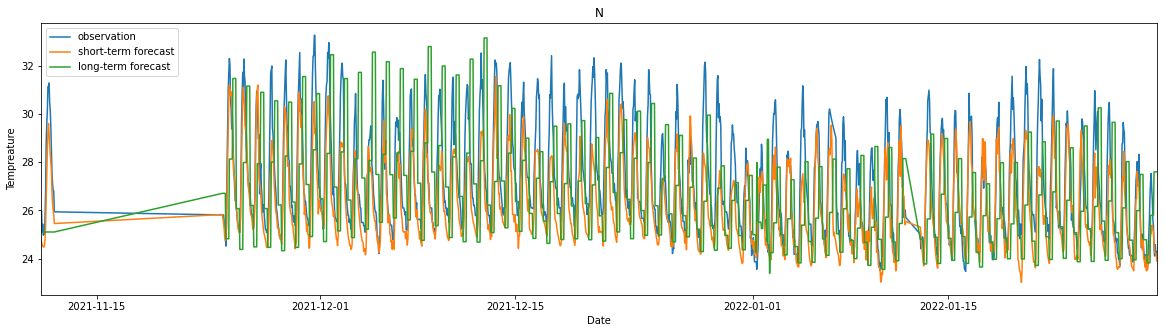

In [14]:
region = "";

for col in df.iloc[:,0:9].columns[range(1,9,2)]:
    
    region=(col[col.find("_")+1:])
    temp = df[{"From","obs_"+region,"short_term_"+region, "long_term_"+region}]

    fig, ax = plt.subplots(1,1,figsize=(20,5))
    cond = (temp["obs_"+region]!=0) & (temp["short_term_"+region]!=0) & (temp["long_term_"+region]!=0)
    # Observations
    plt.plot(temp.loc[cond]["From"],temp.loc[cond]["obs_"+region], label='observation')
    # Short-term forecast
    plt.plot(temp.loc[cond]["From"],temp.loc[cond]["short_term_"+region], label='short-term forecast')
    # Long-term forecast
    plt.plot(temp.loc[cond]["From"],temp.loc[cond]["long_term_"+region], label='long-term forecast')

    plt.xlabel('Date')
    plt.ylabel('Tempreature')
    plt.title(region)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::len(xticks) // 5]) 
    ax.tick_params(axis='x') 
    ax.margins(x=0)
    plt.legend()
    plt.show();

Display data for shorter period of time:

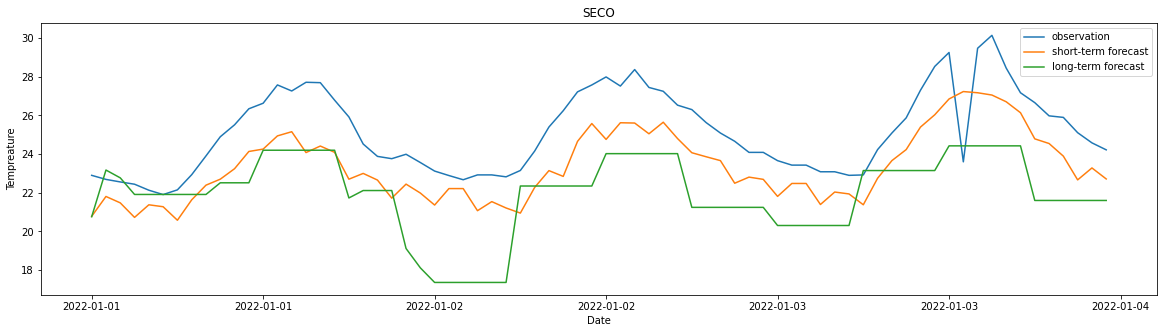

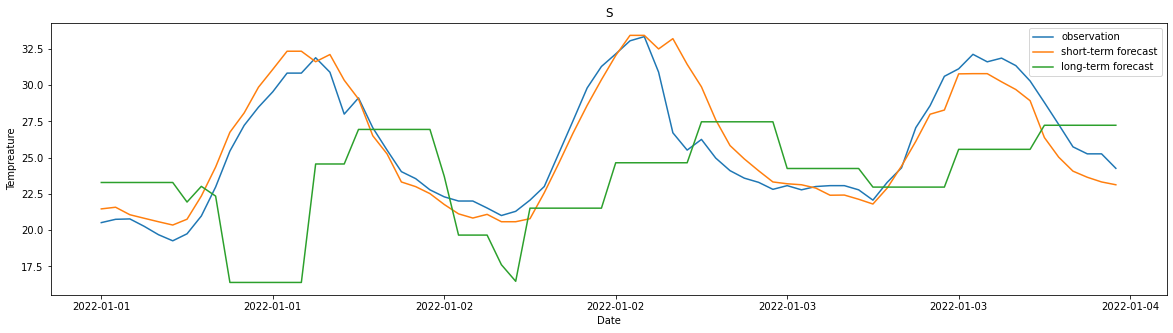

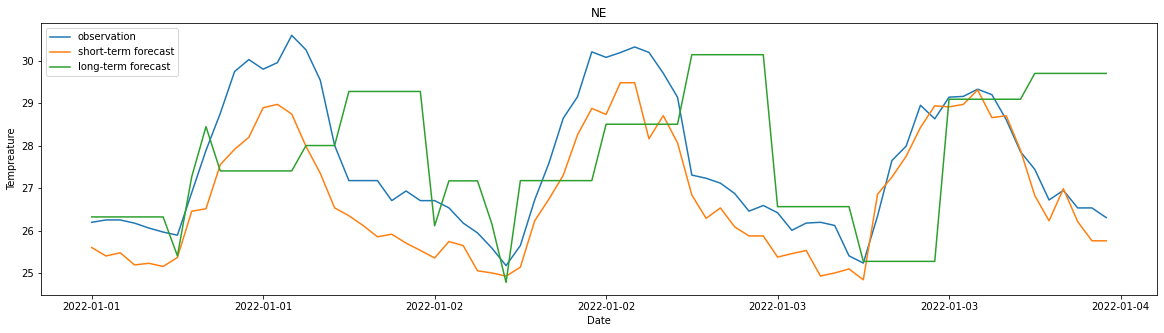

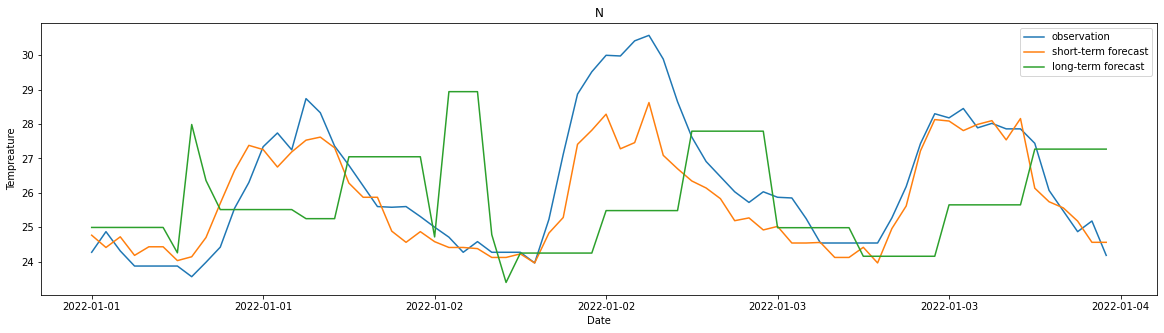

In [15]:
start = datetime.date(2022,1,1)
end = datetime.date(2022,1,3)

region = "";

for col in df.iloc[:,0:9].columns[range(1,9,2)]:
    
    region=(col[col.find("_")+1:])
    temp = df[{"From","obs_"+region,"short_term_"+region,"long_term_"+region}]

    fig, ax = plt.subplots(1,1,figsize=(20,5))
    cond1 = (temp["obs_"+region]!=0) & (temp["short_term_"+region]!=0) & (temp["long_term_"+region]!=0)
    cond2 = (temp["From"].dt.date>=start) & (temp["From"].dt.date<=end)
    # Observations
    plt.plot(temp.loc[cond1 & cond2]["From"],\
             temp.loc[cond1 & cond2]["obs_"+region], label='observation')
    # Short-term forecast
    plt.plot(temp.loc[cond1 & cond2]["From"],\
            temp.loc[cond1 & cond2]["short_term_"+region], label='short-term forecast')
    # Long-term forecast
    plt.plot(temp.loc[cond1 & cond2]["From"],\
            temp.loc[cond1 & cond2]["long_term_"+region], label='long-term forecast')

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Tempreature')
    plt.title(region)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::len(xticks) // 5]) 
    ax.tick_params(axis='x') 
    plt.legend()
    plt.show();

Shift the forecast if required:

In [16]:
d = {'reg': ['SECO','S','NE','N'], 'short_term': [0,0,0,0], 'long_term':[0,-6,-6,-6]} # lag in hours per region
steps = pd.DataFrame(data=d)

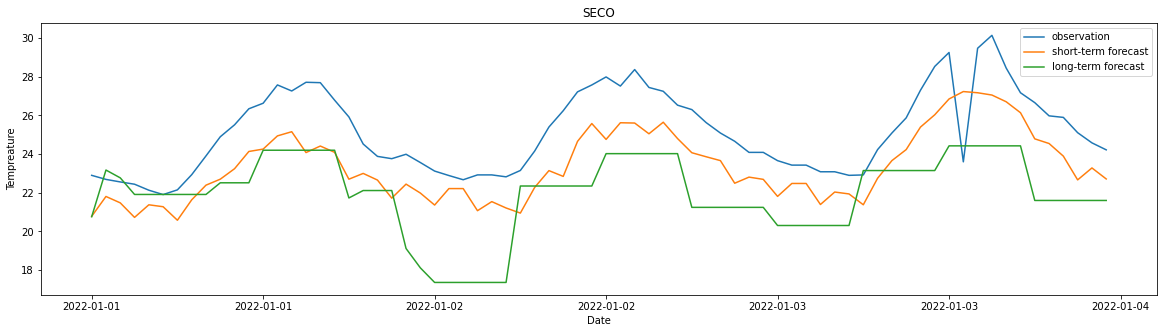

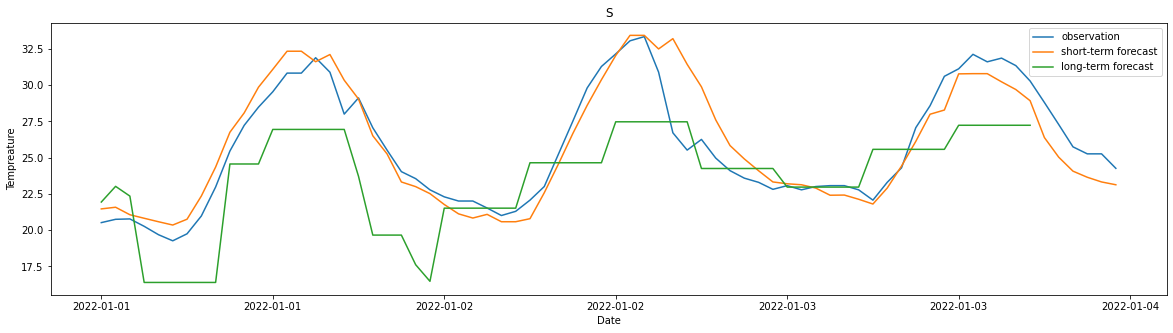

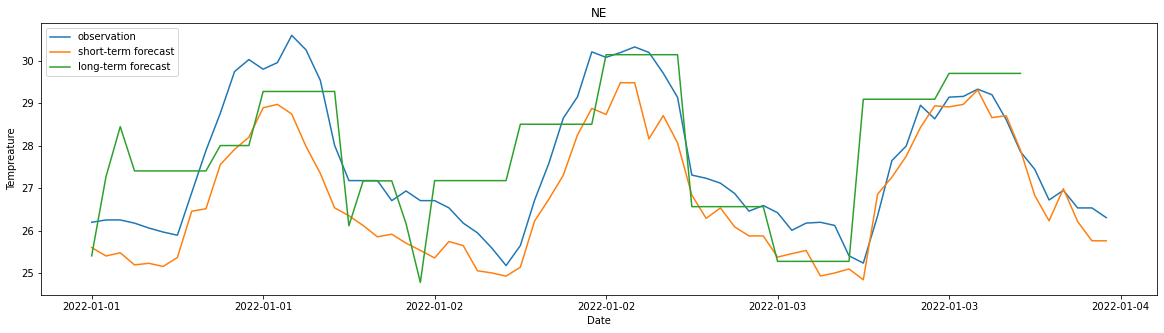

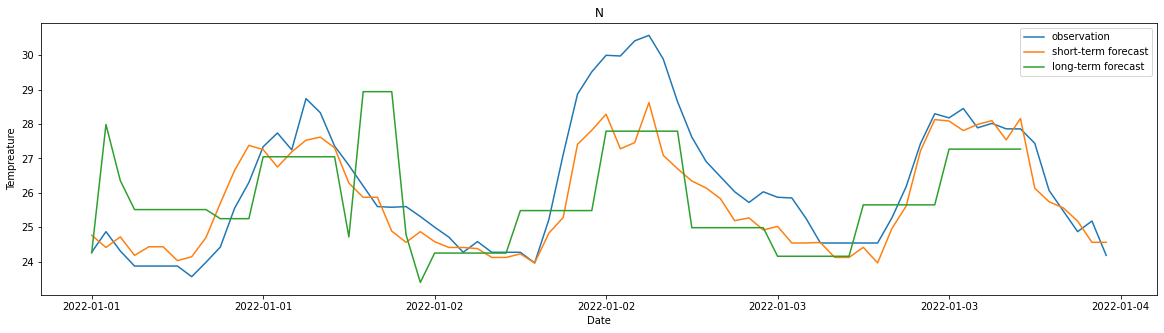

In [17]:
start = datetime.date(2022,1,1)
end = datetime.date(2022,1,3)

region = "";

for col in df.iloc[:,0:9].columns[range(1,9,2)]:
    
    region=(col[col.find("_")+1:])
    temp = df[{"From","obs_"+region,"short_term_"+region,"long_term_"+region}]
    
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    cond1 = (temp["obs_"+region]!=0) & (temp["short_term_"+region]!=0) & (temp["long_term_"+region]!=0)
    cond2 = (temp["From"].dt.date>=start) & (temp["From"].dt.date<=end)
    # Observations
    plt.plot(temp.loc[cond1 & cond2]["From"],\
             temp.loc[cond1 & cond2]["obs_"+region], label='observation')
    # Short-term forecast
    plt.plot(temp.loc[cond1 & cond2]["From"],\
            temp.loc[cond1 & cond2]["short_term_"+region].shift(steps.loc[steps.reg==region].short_term.item()), label='short-term forecast')
    # Long-term forecast
    plt.plot(temp.loc[cond1 & cond2]["From"],\
            temp.loc[cond1 & cond2]["long_term_"+region].shift(steps.loc[steps.reg==region].long_term.item()), label='long-term forecast')
        
    plt.xlabel('Date')
    plt.ylabel('Tempreature')
    plt.title(region)
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::len(xticks) // 5]) 
    ax.tick_params(axis='x') 
    plt.legend()
    plt.show();

## 2. Forecast vs observed temperatures: linear model

In [18]:
shifted_df = df.copy()

In [22]:
region = "";

for col incol in df.iloc[:,0:9].columns[range(1,9,2)]:
    
    region=(col[col.find("_")+1:])
    
    if region == "SECO":
        step = step_SECO
    elif region == "N":
        step = step_N
    else:
        step = step_all
        
    short_term_df["prog_shift_"+region] = temp_df[col].shift(step)

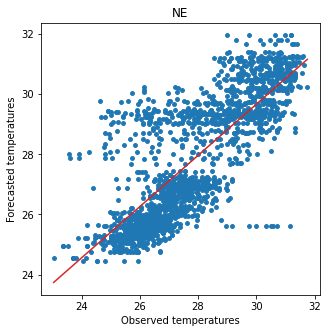

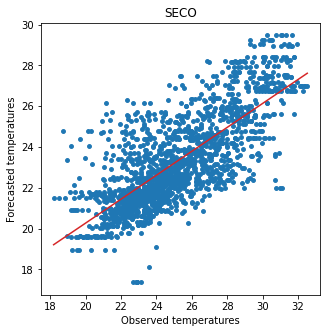

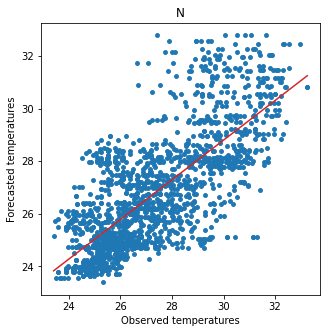

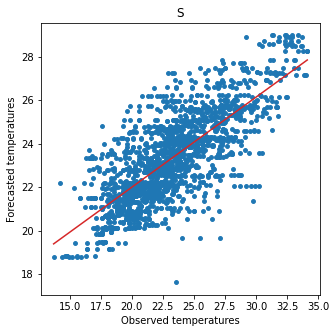

In [24]:
region = "";
OLS_coefs = [];
regions = [];

for col in load_temp.columns[range(2,10,2)]:
    
    region=(col[col.find("_")+1:])
    df = temp_df[{"from","obs_"+region,"prog_"+region,"prog_shift_"+region}]
    
    # Thresholds to remove outliers
    p25 = np.percentile(df.loc[(temp_df["obs_"+region]!=0) & (temp_df["prog_"+region]!=0) & \
               (temp_df["prog_shift_"+region]!=0)]["prog_shift_"+region],25)
    p75 = np.percentile(df.loc[(temp_df["obs_"+region]!=0) & (temp_df["prog_"+region]!=0) & \
               (temp_df["prog_shift_"+region]!=0)]["prog_shift_"+region],75)
    iqr = p75-p25
    upper_threshold = p75+1.5*iqr
    lower_threshold = p25-1.5*iqr
    
    mask_with_outliers = (temp_df["obs_"+region]!=0) & (temp_df["prog_"+region]!=0) & \
    (temp_df["prog_shift_"+region]!=0)
    mask_without_outliers = (temp_df["obs_"+region]!=0) & (temp_df["prog_"+region]!=0) & \
    (temp_df["prog_shift_"+region]!=0) & (temp_df["prog_shift_"+region]>lower_threshold) & \
    (temp_df["prog_shift_"+region]<upper_threshold)
    
    x = temp_df[mask_without_outliers]["obs_"+region]
    y = temp_df[mask_without_outliers]["prog_shift_"+region]

    coefs = np.polyfit(x,y,1)
    regions.append(region)
    OLS_coefs.append(coefs)
    
    plt.figure(figsize=(5,5))
    plt.scatter(x,y,s=15)
    x_values = np.linspace(x.min(),x.max(),num=100)
    y_values = np.polyval(coefs,x_values)
    plt.plot(x_values, y_values, c='C3', label='polyfit(deg=1)')
    plt.xlabel('Observed temperatures')
    plt.ylabel('Forecasted temperatures')
    plt.title(region)
    plt.show();

Compute Pearson correlation coefficient:

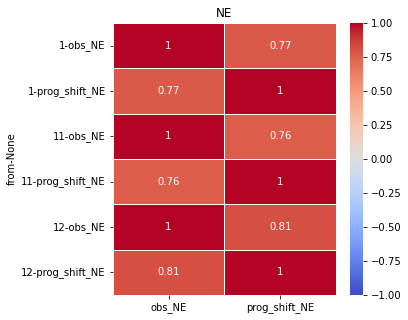

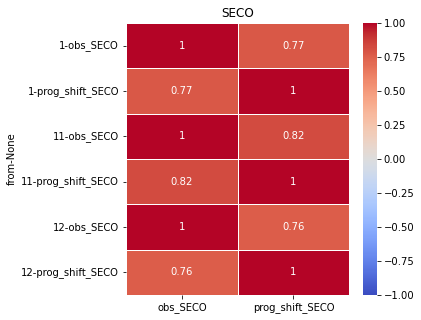

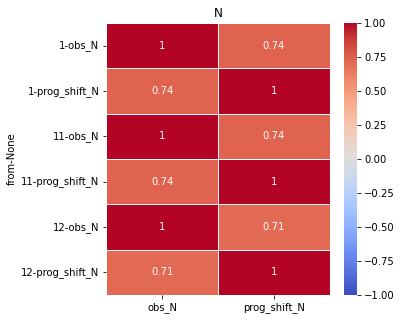

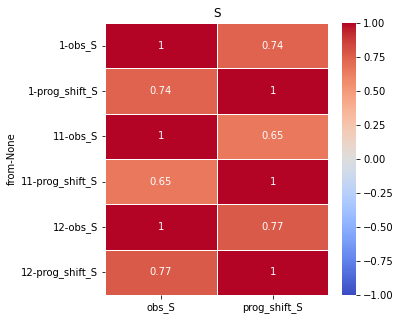

In [25]:
region = "";

for col in load_temp.columns[range(2,10,2)]:
    
    region=(col[col.find("_")+1:])
    df = temp_df[{"from","obs_"+region,"prog_"+region,"prog_shift_"+region}]
    
    # Thresholds to remove outliers
    p25 = np.percentile(df.loc[(temp_df["obs_"+region]!=0) & (temp_df["prog_"+region]!=0) & \
               (temp_df["prog_shift_"+region]!=0)]["prog_shift_"+region],25)
    p75 = np.percentile(df.loc[(temp_df["obs_"+region]!=0) & (temp_df["prog_"+region]!=0) & \
               (temp_df["prog_shift_"+region]!=0)]["prog_shift_"+region],75)
    iqr = p75-p25
    upper_threshold = p75+1.5*iqr
    lower_threshold = p25-1.5*iqr
    
    mask_with_outliers = (temp_df["obs_"+region]!=0) & (temp_df["prog_"+region]!=0) & \
    (temp_df["prog_shift_"+region]!=0)
    mask_without_outliers = (temp_df["obs_"+region]!=0) & (temp_df["prog_"+region]!=0) & \
    (temp_df["prog_shift_"+region]!=0) & (temp_df["prog_shift_"+region]>lower_threshold) & \
    (temp_df["prog_shift_"+region]<upper_threshold)
    
    x = temp_df[mask_without_outliers]["obs_"+region]
    y = temp_df[mask_without_outliers]["prog_shift_"+region]

    dfcorr = pd.concat([temp_df[mask_without_outliers]["from"],\
                    temp_df[mask_without_outliers]["obs_"+region],\
                    temp_df[mask_without_outliers]["prog_shift_"+region]],axis=1)
    
    fig, ax = plt.subplots(figsize=(5,5))
    plt.title(region);
    sns.heatmap(dfcorr.groupby(dfcorr["from"].dt.month).corr(),vmin=-1, vmax=1, cmap="coolwarm", \
                annot=True, linewidths=.5, ax=ax)

In [26]:
calculated_coefs = pd.DataFrame({"region":regions,"coef_a":np.array(OLS_coefs)[:,0],\
                                 "coef_b":np.array(OLS_coefs)[:,1]})

Calculated coefficients of linear regression:

In [ ]:
calculated_coefs

,region,coef_a,coef_b
0,NE,0.852517,4.093411
1,SECO,0.587138,8.526268
2,N,0.753298,6.203302
3,S,0.414484,13.704208
